Sentiment Analysis using vader in twitter dataset (For Four Labels)
Positive , Negative , Netural and Irrelevant

In [7]:
!pip install vaderSentiment

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from IPython.display import display
import ipywidgets as widgets

Load Google Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load CSV Files

In [10]:
# Define file paths
training_file = '/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/TwitterDataset/twitter_training.csv'
validation_file = '/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/TwitterDataset/twitter_training.csv'

# Load data
# Load CSV without header and assign column names
df_train = pd.read_csv(training_file,
                       header=None,
                       names=['id', 'entity', 'sentiment', 'text'])
df_valid = pd.read_csv(validation_file,
                        header=None,
                       names=['id', 'entity', 'sentiment', 'text'])

# Preview the data
print("Preview the training data")
display(df_train.head())
print()
print()
print("Preview the validation data")
display(df_valid.head())


Preview the training data


,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...




Preview the validation data


,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Make Three Labels, Replace the irrevalent with neutral

In [11]:
# Replace 'Irrelevant' with 'Neutral' in the sentiment column
df_train['sentiment'] = df_train['sentiment'].replace('Irrelevant', 'Neutral')
df_valid['sentiment'] = df_valid['sentiment'].replace('Irrelevant', 'Neutral')

# Verify the changes
print("Updated sentiment labels in training data:")
print(df_train['sentiment'].value_counts())
print()
print("Updated sentiment labels in validation data:")
print(df_valid['sentiment'].value_counts())

Updated sentiment labels in training data:
sentiment
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64

Updated sentiment labels in validation data:
sentiment
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64


Text preprocessing steps:

-Converting text to lowercase

-Removing punctuation

-Removing stopwords

-Removing numbers

-Stemming (to reduce words to their base forms)

-Removing extra whitespaces

In [12]:
# Download stopwords if not done before
import nltk
nltk.download('stopwords')

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
analyzer = SentimentIntensityAnalyzer()

# Text preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Remove stopwords + stemming
    return " ".join(tokens)

# Apply preprocessing
df_train['clean_text'] = df_train['text'].apply(preprocess_text)
df_valid['clean_text'] = df_valid['text'].apply(preprocess_text)

# Preview the data
print("Preview the training data after text preprocessing")
display(df_train.head())
print()
print()
print("Preview the validation data after text preprocessing")
display(df_valid.head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preview the training data after text preprocessing


,id,entity,sentiment,text,clean_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder




Preview the validation data after text preprocessing


,id,entity,sentiment,text,clean_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder


Extract Varder Feature

In [13]:
# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to extract VADER features
def extract_vader_features(df, text_column):
    vader_scores = df[text_column].apply(lambda x: analyzer.polarity_scores(str(x)))
    df['vader_pos'] = vader_scores.apply(lambda x: x['pos'])
    df['vader_neu'] = vader_scores.apply(lambda x: x['neu'])
    df['vader_neg'] = vader_scores.apply(lambda x: x['neg'])
    df['vader_compound'] = vader_scores.apply(lambda x: x['compound'])
    return df

# Apply VADER features extraction
df_train = extract_vader_features(df_train, 'clean_text')
df_valid = extract_vader_features(df_valid, 'clean_text')

# Preview the data
print("Preview the training data after varder feture extraction")
display(df_train.head())
print()
print()
print("Preview the validation data after varder feature extraction")
display(df_valid.head())


Preview the training data after varder feture extraction


,id,entity,sentiment,text,clean_text,vader_pos,vader_neu,vader_neg,vader_compound
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder,0.0,0.390,0.610,-0.6908
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,0.0,0.299,0.701,-0.6908
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill,0.0,0.390,0.610,-0.6908
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder,0.0,0.390,0.610,-0.6908
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder,0.0,0.390,0.610,-0.6908




Preview the validation data after varder feature extraction


,id,entity,sentiment,text,clean_text,vader_pos,vader_neu,vader_neg,vader_compound
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder,0.0,0.390,0.610,-0.6908
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,0.0,0.299,0.701,-0.6908
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill,0.0,0.390,0.610,-0.6908
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder,0.0,0.390,0.610,-0.6908
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder,0.0,0.390,0.610,-0.6908


In [14]:
# Vectorize text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_text = tfidf_vectorizer.fit_transform(df_train['clean_text'])
X_valid_text = tfidf_vectorizer.transform(df_valid['clean_text'])

# Preview the data
print("Preview the training data after varder feture vectorization using TF-IDF")
display(df_train.head())
print()
print()
print("Preview the validation data after varder feature vectorization using TF-IDF")
display(df_valid.head())

Preview the training data after varder feture vectorization using TF-IDF


,id,entity,sentiment,text,clean_text,vader_pos,vader_neu,vader_neg,vader_compound
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder,0.0,0.390,0.610,-0.6908
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,0.0,0.299,0.701,-0.6908
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill,0.0,0.390,0.610,-0.6908
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder,0.0,0.390,0.610,-0.6908
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder,0.0,0.390,0.610,-0.6908




Preview the validation data after varder feature vectorization using TF-IDF


,id,entity,sentiment,text,clean_text,vader_pos,vader_neu,vader_neg,vader_compound
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder,0.0,0.390,0.610,-0.6908
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,0.0,0.299,0.701,-0.6908
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill,0.0,0.390,0.610,-0.6908
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder,0.0,0.390,0.610,-0.6908
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder,0.0,0.390,0.610,-0.6908


In [15]:
# Normalize VADER features
scaler = MinMaxScaler()
X_train_vader = scaler.fit_transform(df_train[['vader_pos', 'vader_neu', 'vader_neg', 'vader_compound']])
X_valid_vader = scaler.transform(df_valid[['vader_pos', 'vader_neu', 'vader_neg', 'vader_compound']])

# Combine TF-IDF and VADER features
X_train_combined = hstack([X_train_text, X_train_vader])
X_valid_combined = hstack([X_valid_text, X_valid_vader])

y_train = df_train['sentiment']
y_valid = df_valid['sentiment']

#display combined fetuures


# Convert sparse matrices to dense arrays
X_train_combined_dense = X_train_combined.toarray()
X_valid_combined_dense = X_valid_combined.toarray()

# Combine features and target into a DataFrame
df_train_combined = pd.DataFrame(X_train_combined_dense)
df_train_combined['sentiment'] = y_train.values  # Append y_train

df_valid_combined = pd.DataFrame(X_valid_combined_dense)
df_valid_combined['sentiment'] = y_valid.values  # Append y_valid

# Display the combined DataFrames
print("Combined Training Features with Sentiment Labels:")
display(df_train_combined.head())

print()
print()

print("Combined Validation Features with Sentiment Labels:")
display(df_valid_combined.head())




Combined Training Features with Sentiment Labels:


,0,1,2,3,4,5,6,7,8,9,...,4995,4996,4997,4998,4999,5000,5001,5002,5003,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.299,0.701,0.151369,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive




Combined Validation Features with Sentiment Labels:


,0,1,2,3,4,5,6,7,8,9,...,4995,4996,4997,4998,4999,5000,5001,5002,5003,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.299,0.701,0.151369,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390,0.610,0.151369,Positive


Train with different classification algorithm to find the best classifiers

In [16]:
# Define models to compare
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": LinearSVC(max_iter=1000)
}

Train and predict with validation data and compare the accuracy results

In [17]:
# Store results
results = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    print(f"\n🔹 {name} Results:")
    start_train = time.time()
    model.fit(X_train_combined, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(X_valid_combined)
    end_test = time.time()

    accuracy = accuracy_score(y_valid, y_pred)
    misclassification_rate = 1 - accuracy
    training_time = end_train - start_train
    testing_time = end_test - start_test
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_valid, y_pred, average='weighted', zero_division=0)

    print("accuracy:",accuracy)
    print("misclassification_rate:",misclassification_rate)
    print("training_time:",training_time)
    print("testing_time:",testing_time)
    print("precision:",precision)
    print("recall:",recall)
    print("f1_score:",f1_score)

    results[name] = {
        "accuracy": accuracy,
        "misclassification_rate": misclassification_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "training_time": training_time,
        "testing_time": testing_time,
        "model": model,
        "y_pred": y_pred,
        "confusion_matrix": confusion_matrix(y_valid, y_pred),
        "classification_report": classification_report(y_valid, y_pred, output_dict=True, zero_division=0)
    }
    display(results)


🔹 Naive Bayes Results:
accuracy: 0.7175089044214135
misclassification_rate: 0.28249109557858654
training_time: 0.27282214164733887
testing_time: 0.026691675186157227
precision: 0.71927913023729
recall: 0.7175089044214135
f1_score: 0.7167112256713575


{'Naive Bayes': {'accuracy': 0.7175089044214135,
  'misclassification_rate': 0.28249109557858654,
  'precision': 0.71927913023729,
  'recall': 0.7175089044214135,
  'f1_score': 0.7167112256713575,
  'training_time': 0.27282214164733887,
  'testing_time': 0.026691675186157227,
  'model': MultinomialNB(),
  'y_pred': array(['Positive', 'Neutral', 'Neutral', ..., 'Negative', 'Negative',
         'Negative'], dtype='<U8'),
  'confusion_matrix': array([[15927,  5120,  1495],
         [ 3606, 24192,  3510],
         [ 1896,  5470, 13466]]),
  'classification_report': {'Negative': {'precision': 0.7432451350972981,
    'recall': 0.7065477774820336,
    'f1-score': 0.7244320120079143,
    'support': 22542.0},
   'Neutral': {'precision': 0.6955321718130067,
    'recall': 0.7727098505174397,
    'f1-score': 0.7320926009986383,
    'support': 31308.0},
   'Positive': {'precision': 0.7290347030480212,
    'recall': 0.6464093701996928,
    'f1-score': 0.6852403124443427,
    'support': 20832.0},
   


🔹 Logistic Regression Results:
accuracy: 0.7659810931683672
misclassification_rate: 0.23401890683163284
training_time: 13.754461765289307
testing_time: 0.034349918365478516
precision: 0.7675541877351285
recall: 0.7659810931683672
f1_score: 0.7653929323370411


{'Naive Bayes': {'accuracy': 0.7175089044214135,
  'misclassification_rate': 0.28249109557858654,
  'precision': 0.71927913023729,
  'recall': 0.7175089044214135,
  'f1_score': 0.7167112256713575,
  'training_time': 0.27282214164733887,
  'testing_time': 0.026691675186157227,
  'model': MultinomialNB(),
  'y_pred': array(['Positive', 'Neutral', 'Neutral', ..., 'Negative', 'Negative',
         'Negative'], dtype='<U8'),
  'confusion_matrix': array([[15927,  5120,  1495],
         [ 3606, 24192,  3510],
         [ 1896,  5470, 13466]]),
  'classification_report': {'Negative': {'precision': 0.7432451350972981,
    'recall': 0.7065477774820336,
    'f1-score': 0.7244320120079143,
    'support': 22542.0},
   'Neutral': {'precision': 0.6955321718130067,
    'recall': 0.7727098505174397,
    'f1-score': 0.7320926009986383,
    'support': 31308.0},
   'Positive': {'precision': 0.7290347030480212,
    'recall': 0.6464093701996928,
    'f1-score': 0.6852403124443427,
    'support': 20832.0},
   


🔹 Random Forest Results:
accuracy: 0.9681717147371522
misclassification_rate: 0.031828285262847755
training_time: 204.7562539577484
testing_time: 5.887010335922241
precision: 0.9693711989319567
recall: 0.9681717147371522
f1_score: 0.9682292729446775


{'Naive Bayes': {'accuracy': 0.7175089044214135,
  'misclassification_rate': 0.28249109557858654,
  'precision': 0.71927913023729,
  'recall': 0.7175089044214135,
  'f1_score': 0.7167112256713575,
  'training_time': 0.27282214164733887,
  'testing_time': 0.026691675186157227,
  'model': MultinomialNB(),
  'y_pred': array(['Positive', 'Neutral', 'Neutral', ..., 'Negative', 'Negative',
         'Negative'], dtype='<U8'),
  'confusion_matrix': array([[15927,  5120,  1495],
         [ 3606, 24192,  3510],
         [ 1896,  5470, 13466]]),
  'classification_report': {'Negative': {'precision': 0.7432451350972981,
    'recall': 0.7065477774820336,
    'f1-score': 0.7244320120079143,
    'support': 22542.0},
   'Neutral': {'precision': 0.6955321718130067,
    'recall': 0.7727098505174397,
    'f1-score': 0.7320926009986383,
    'support': 31308.0},
   'Positive': {'precision': 0.7290347030480212,
    'recall': 0.6464093701996928,
    'f1-score': 0.6852403124443427,
    'support': 20832.0},
   


🔹 Linear SVM Results:
accuracy: 0.7873517045606706
misclassification_rate: 0.2126482954393294
training_time: 3.819321632385254
testing_time: 0.02364516258239746
precision: 0.7879420879619651
recall: 0.7873517045606706
f1_score: 0.7870755952261839


{'Naive Bayes': {'accuracy': 0.7175089044214135,
  'misclassification_rate': 0.28249109557858654,
  'precision': 0.71927913023729,
  'recall': 0.7175089044214135,
  'f1_score': 0.7167112256713575,
  'training_time': 0.27282214164733887,
  'testing_time': 0.026691675186157227,
  'model': MultinomialNB(),
  'y_pred': array(['Positive', 'Neutral', 'Neutral', ..., 'Negative', 'Negative',
         'Negative'], dtype='<U8'),
  'confusion_matrix': array([[15927,  5120,  1495],
         [ 3606, 24192,  3510],
         [ 1896,  5470, 13466]]),
  'classification_report': {'Negative': {'precision': 0.7432451350972981,
    'recall': 0.7065477774820336,
    'f1-score': 0.7244320120079143,
    'support': 22542.0},
   'Neutral': {'precision': 0.6955321718130067,
    'recall': 0.7727098505174397,
    'f1-score': 0.7320926009986383,
    'support': 31308.0},
   'Positive': {'precision': 0.7290347030480212,
    'recall': 0.6464093701996928,
    'f1-score': 0.6852403124443427,
    'support': 20832.0},
   

Compare models according to F1-Score, Training Time and Testing Time

In [18]:
# Display model comparison in a table view
comparison_df = pd.DataFrame([
    {"Model Name": name,
     "F1 Score": results[name]['f1_score'],
     "Training Time (s)": results[name]['training_time'],
     "Testing Time (s)": results[name]['testing_time']}
    for name in results
])

display(comparison_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True))



,Model Name,F1 Score,Training Time (s),Testing Time (s)
0,Random Forest,0.968229,204.756254,5.887010
1,Linear SVM,0.787076,3.819322,0.023645
2,Logistic Regression,0.765393,13.754462,0.034350
3,Naive Bayes,0.716711,0.272822,0.026692


Compare Training Time and Accuracy of each model using bar chart

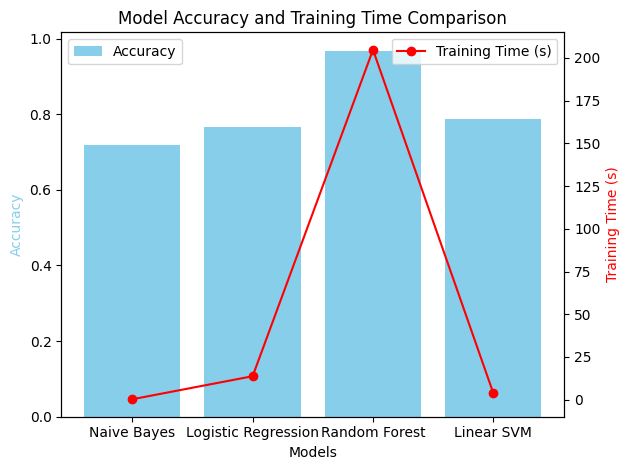

In [19]:
# Bar chart for model comparison
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
training_times = [results[m]['training_time'] for m in model_names]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(model_names, accuracies, color='skyblue', label='Accuracy')
ax2.plot(model_names, training_times, color='red', marker='o', label='Training Time (s)')

ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy', color='skyblue')
ax2.set_ylabel('Training Time (s)', color='red')
plt.title('Model Accuracy and Training Time Comparison')
fig.tight_layout()

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Choose the best model by classification F1-score and its classification metric report

In [20]:
# Identify the best model based on F1 score
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model_results = results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_model_results['accuracy']:.4f}")
print(f"Misclassification Rate: {best_model_results['misclassification_rate']:.4f}")
print(f"Precision: {best_model_results['precision']:.4f}")
print(f"Recall: {best_model_results['recall']:.4f}")
print(f"F1 Score: {best_model_results['f1_score']:.4f}")
print(f"Training Time: {best_model_results['training_time']:.2f} seconds")
print(f"Testing Time: {best_model_results['testing_time']:.2f} seconds")
print("Classification Report for Best Model:\n")
print(classification_report(y_valid, best_model_results['y_pred']))



Best Model: Random Forest
Accuracy: 0.9682
Misclassification Rate: 0.0318
Precision: 0.9694
Recall: 0.9682
F1 Score: 0.9682
Training Time: 204.76 seconds
Testing Time: 5.89 seconds
Classification Report for Best Model:

              precision    recall  f1-score   support

    Negative       0.99      0.95      0.97     22542
     Neutral       0.94      0.99      0.97     31308
    Positive       0.99      0.95      0.97     20832

    accuracy                           0.97     74682
   macro avg       0.97      0.96      0.97     74682
weighted avg       0.97      0.97      0.97     74682



Confuaion Matrix of best model

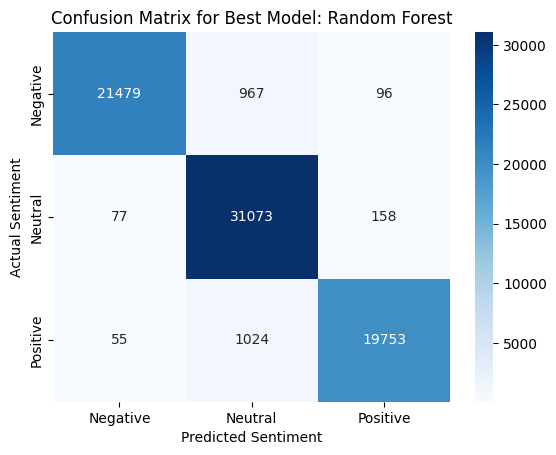

In [21]:
# Plot confusion matrix for the best model
sns.heatmap(best_model_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=models[best_model_name].classes_ if hasattr(models[best_model_name], 'classes_') else y_train.unique(),
            yticklabels=models[best_model_name].classes_ if hasattr(models[best_model_name], 'classes_') else y_train.unique())
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title(f'Confusion Matrix for Best Model: {best_model_name}')
plt.show()

Apply best model in real world Sentiment Analysis GUI

In [22]:
best_model = best_model_results['model']
# Define the list of sentences to test
test_sentences = [
    "Stuck at home?",
    "Battlefield 4 is such a masterpiece, I still come back and play it to this day",
    "I love ordering things for people with Amazon",
    "At the same time, despite the fact that there are currently some 100 million people living below the poverty line.",
    "sooooo much unnecessary shit from Amazon"
]

# Convert sentences into a DataFrame
test_df = pd.DataFrame({"clean_text": test_sentences})

# Extract VADER features
test_df = extract_vader_features(test_df, 'clean_text')

# Transform text using TF-IDF vectorizer
test_text_vector = tfidf_vectorizer.transform(test_df['clean_text'])

# Transform VADER features using the scaler
test_vader_features = scaler.transform(test_df[['vader_pos', 'vader_neu', 'vader_neg', 'vader_compound']])

# Combine TF-IDF and VADER features
test_combined = hstack([test_text_vector, test_vader_features])

# Predict sentiment using the best model
predictions = best_model.predict(test_combined)

# Print results
for sentence, prediction in zip(test_sentences, predictions):
    print(f"Sentence: {sentence}\nPredicted Sentiment: {prediction}\n")

Sentence: Stuck at home?
Predicted Sentiment: Neutral

Sentence: Battlefield 4 is such a masterpiece, I still come back and play it to this day
Predicted Sentiment: Positive

Sentence: I love ordering things for people with Amazon
Predicted Sentiment: Positive

Sentence: At the same time, despite the fact that there are currently some 100 million people living below the poverty line.
Predicted Sentiment: Neutral

Sentence: sooooo much unnecessary shit from Amazon
Predicted Sentiment: Negative



In [23]:
# GUI for real-world sentiment analysis
# GUI-like sentiment analysis using ipywidgets for Colab
best_model = best_model_results['model']
text_input = widgets.Text(
    value='',
    placeholder='Enter text for sentiment analysis...',
    description='Text:',
    layout=widgets.Layout(width='100%')
)

output = widgets.Output()

def analyze_sentiment_colab(change):
    with output:
        output.clear_output()
        input_text = text_input.value
        if not input_text:
            print("Please enter text for sentiment analysis.")
            return

        input_df = pd.DataFrame({"clean_text": [input_text]})
        input_df = extract_vader_features(input_df, 'clean_text')
        input_text_vector = tfidf_vectorizer.transform(input_df['clean_text'])
        input_vader_features = scaler.transform(input_df[['vader_pos', 'vader_neu', 'vader_neg', 'vader_compound']])
        input_combined = hstack([input_text_vector, input_vader_features])

        prediction = best_model.predict(input_combined)[0]
        print(f"Predicted Sentiment: {prediction}")

text_input.on_submit(analyze_sentiment_colab)

display(text_input, output)

Text(value='', description='Text:', layout=Layout(width='100%'), placeholder='Enter text for sentiment analysi…

Output()

Predicted Sentiment: Negative
